<a href="https://colab.research.google.com/github/medvedevse/AI_training/blob/main/hw_03_gradient_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Решение задачи регрессии с помощью градиентного бустинга
В этом домашнем задании вы примените алгоритм градиентного бустинга к задаче регрессии. Мы будем решать задачу предсказания популярности трека на музыкальной платформе по различным характеристикам (имя музыканта, продолжительность, а также численные характеристика трека, такие как размер, громкость, лад (минор/мажор), энергичность, акустичность и т.д.

## Почему именно градиентный бустинг?
Обычно градиентный бустинг дает в стандартных задачах машинного обучения на табличных данных умеренный прирост по сравнению со случайным лесом: несколько процентных пунктов целевой метрики. В предлагаемой вам задаче все иначе: градиентный бустинг в библиотеке `CatBoost` здесь дает по сравнению с бейзлайном **четырехкратный** прирост по метрике $R^2$. Помимо самого алгоритма бустинга, это связано со способностью `CatBoost` качественно кодировать категориальные признаки, тогда как стандартные модели машинного обучения в `sklearn` (как и альтернативные реализации градиентного бустинга) по умолчанию этого делать не умеют. При выполнении домашнего задания вам предстоит в этом убедиться.

## Данные и посылка
в этом задании мы будем проверять и оценивать вашу посылку так, как это происходит на конкурсах по машинному обучению (например, на платформе kaggle.com). Для этого мы предварительно разделили данные в задании на две части.

1. data_train.csv. В каждой строчке файла data_train.csv содержатся следующие поля:
* `track_id` --- уникальный ключ, который мы будем использовать в качестве `pd.Index`
* `artist_name` --- имя исполнителя (важный категориальный признак, качественное использование которого кратно повышает качество модели)
* `track_name` --- название трека. Это поле не используется в базовом решении и в авторском решении, но никто не мешает вам попробовать его использовать
* `acousticness` --- числовой признак
* `danceability` --- числовой признак
* `duration_ms` --- числовой признак
* `energy` --- числовой признак
* `instrumentalness` --- числовой признак
* `key` --- категориальный признак
* `liveliness` --- числовой признак
* `loudness` --- числовой признак
* `mode` --- бинарный признак
* `speechiness`	--- числовой признак
* `tempo` --- числовой признак
* `time_signature` --- категориальный признак
* `valence` --- числовой признак
* `popularity` --- целевая переменная, принимающая целое значение от 1 до 100.

На этом наборе данных вам необходимо создать и обучить модель.

2. data_scoring.csv. В каждой строчке файла data_scoring.csv указаны признаки тестовых объектов. Предсказания для этого набора необходимо записать в файл submission.csv и сдать в соответствующий шаг на Stepik. Количество попыток ограничено 100 штук.
Также мы предоставляем файл [sample_submission.csv](https://drive.google.com/file/d/1QlQnKFOej3hg5tNcjx4DRrd6QPNdTl_7/view?usp=share_link). Это образец посылки --- ваш файл submission.csv должен быть оформлен таким же образом. Обратите внимание, что порядок строчек в submission должен быть такой же, как и в data_scoring.csv!

## Целевая метрика
Целевая метрика в этой задаче --- $R^2$. Именно по ней система будет выставлять вам баллы. Минимальное значение $R^2$, за которое ставятся баллы, равно $lb=0.450$. Чтобы набрать полный балл за задание, необходимо набрать $ub=0.475$.
Оценка выставляется по формуле
$$\begin{cases}
0, & score \leqslant lb,\\
10 \cdot \frac{score - lb}{ub - lb}, & lb < score < ub,\\
10, & score \geqslant ub.
\end{cases}$$

## Бейзлайн
В этом ноутбуке приведен бейзлайн на основе случайного леса, который оценивается в 0 баллов на Stepik (дает $R^2=0.15$).

## Ход работы
Для получения необходимого качества предлагаем использовать модель `catboost.CatBoostRegressor`. Эта модель с любыми параметрами скорее всего принесет вам какие-то баллы за задание. При этом максимальный балл принесет модель, у которой подобран оптимальный параметр глубины. Для нахождения этого параметра мы предлагаем использовать кросс-валидацию, встроенную в `catboost`.

Обратите внимание, что кодирование категориальных признаков, принятое по умолчанию в `catboost`, работает лучше, чем выделение числовых признаков с помощью One-hot Encoding. Поэтому вам этот этап обработки данных не понадобится, хотя он и реализован в бейзлайне. Для того, чтобы указать `catboost`, какие данные являются категориальными, необходимо использовать параметр `cat_features` при создании `catboost.Pool`.

Желаем удачи!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [2]:

!pip install scikit-learn==1.2 # Новая версия One-hot encoding доступна только в sklearn 1.2

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 62.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


Скачиваем данные

In [3]:
!gdown 1G-dH-66bWsl16RC9n8AX4370I2LRkgzO  # data_train.csv
!gdown 1pVrpyO5ZxouaDGYW29L0mWUnognmiZIq  # data_scoring.csv

Downloading...
From: https://drive.google.com/uc?id=1G-dH-66bWsl16RC9n8AX4370I2LRkgzO
To: /content/data_train.csv
100% 9.44M/9.44M [00:00<00:00, 45.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pVrpyO5ZxouaDGYW29L0mWUnognmiZIq
To: /content/data_scoring.csv
100% 9.28M/9.28M [00:00<00:00, 107MB/s]


In [4]:
data = pd.read_csv('data_train.csv', index_col='track_id')
data.head()

,artist_name,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
track_id,,,,,,,,,,,,,,,,
77WL0prmlUqQ3Uv2H7X8Tv,Houzemaster,My Way,0.0775,0.703,199523,0.271,0.834000,6,0.1080,-14.608,0,0.0744,120.007,4,0.7000,0
5QTxCUGrKdbxEWKedcF7Ty,Magnus Foss,Doesn't Matter,0.0546,0.759,198000,0.567,0.870000,1,0.0838,-10.655,1,0.0444,120.006,4,0.0969,0
7rreyET2avyDiKloE6fjBg,Giriboy,BangBup,0.1420,0.555,167584,0.828,0.000000,1,0.3360,-3.555,1,0.3830,74.954,4,0.6220,15
0yLrdldrWbq8U4A5ilvF6g,Kip Moore,Love You To The Moon,0.3160,0.745,223880,0.640,0.000007,7,0.0804,-6.095,1,0.0342,101.025,4,0.8990,50
12PL3IiJsrN5254htzLWRO,Bobina,The Reason,0.1860,0.513,189600,0.818,0.000000,3,0.1040,-3.693,1,0.0332,99.972,4,0.2160,11


Разбиваем на train и test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['popularity']),
    data['popularity'])

cat_features = ['artist_name', 'key', 'time_signature']



Кодируем категориальные данные с помощью `sklearn.preprocessing.OneHotEncoder`. Формируем полный датасет с помощью `pd.concat`.

In [ ]:
encoder = OneHotEncoder(max_categories=30, sparse=False, handle_unknown='ignore')
train_cat_data = pd.DataFrame(encoder.fit_transform(X_train[cat_features[1:]]),
                              index=X_train.index,
                              columns=encoder.get_feature_names_out())

test_cat_data = pd.DataFrame(encoder.transform(X_test[cat_features[1:]]),
                             index=X_test.index,
                             columns=encoder.get_feature_names_out())

full_train_data = pd.concat([X_train.drop(columns=cat_features + ['track_name']),
                             train_cat_data],
                            axis='columns')
full_test_data = pd.concat([X_test.drop(columns=cat_features + ['track_name']),
                            test_cat_data],
                           axis='columns')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Перебираем параметр `max_depth` у модели sklearn.ensemble.RandomForestRegressor. Считаем метрики на train, test.

In [ ]:
rf_metrics = []
for depth in tqdm(range(8, 17)):
    rf_model = RandomForestRegressor(n_estimators=100,
                                     max_depth=depth,
                                     n_jobs=-1).fit(
        full_train_data,
        y_train)
    rf_metrics.append({'train': r2_score(y_train, rf_model.predict(full_train_data)),
                       'test': r2_score(y_test, rf_model.predict(full_test_data))})

100%|██████████| 9/9 [04:23<00:00, 29.33s/it]


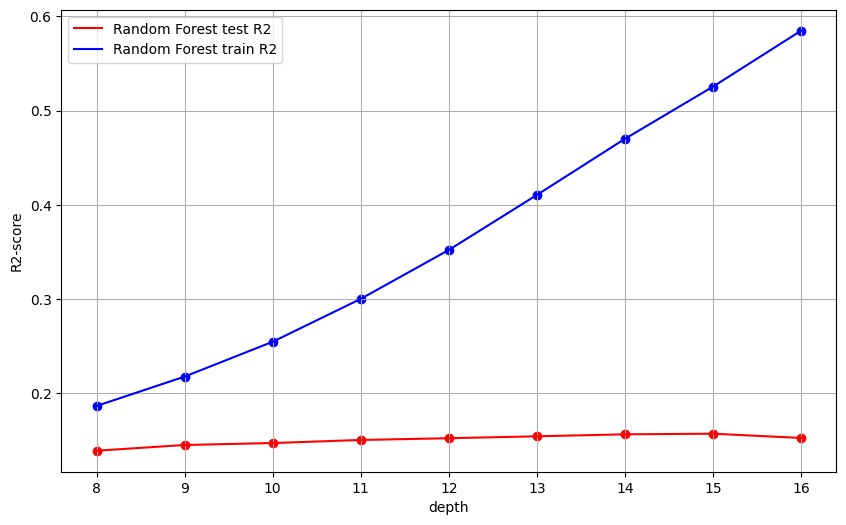

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(8, 17),
         [item['test'] for item in rf_metrics],
         label='Random Forest test R2', color='red')
plt.scatter(np.arange(8, 17),
            [item['test'] for item in rf_metrics],
            color='red')

plt.plot(np.arange(8, 17),
         [item['train'] for item in rf_metrics],
         label='Random Forest train R2', color='blue')
plt.scatter(np.arange(8, 17),
            [item['train'] for item in rf_metrics],
            color='blue')

plt.xlabel('depth')
plt.ylabel('R2-score')
plt.grid()
plt.legend()

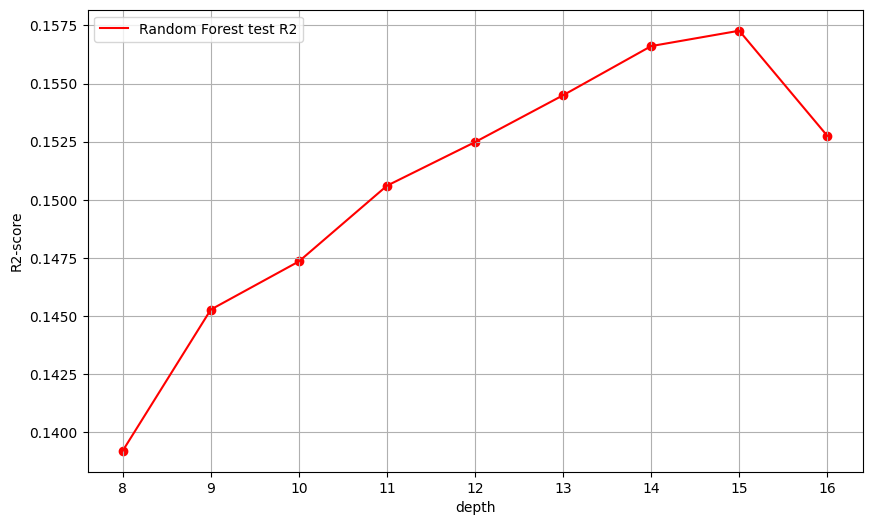

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(8, 17),
         [item['test'] for item in rf_metrics],
         label='Random Forest test R2', color='red')
plt.scatter(np.arange(8, 17),
            [item['test'] for item in rf_metrics],
            color='red')

plt.xlabel('depth')
plt.ylabel('R2-score')
plt.grid()
plt.legend()

Оптимальный параметр глубины --- `max_depth=15`. Обучим окончательную модель, предскажем ответы на `data_scoring` и сформируем submission.

In [ ]:
data_scoring = pd.read_csv('data_scoring.csv', index_col='track_id')
data_scoring.head()

,artist_name,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
track_id,,,,,,,,,,,,,,,
6D8WgDaIuyirn6egGauzVK,RITUAL,Love Me Back,0.498,0.745,178233,0.664,0.000008,1,0.0777,-4.280,1,0.0613,108.067,4,0.468
7ywsuXRTQ9xNKhZSmSD3Q0,Dalton Mauldin,Nights Without You,0.221,0.539,157751,0.536,0.000000,5,0.4940,-8.722,1,0.0552,183.784,4,0.725
1eoGO19WEflJbAV8BLebhr,Pandrezz,Orion,0.805,0.684,152000,0.255,0.790000,10,0.0884,-9.381,0,0.0445,84.226,4,0.330
3G79AJm9H5lKnngSgBT21L,Mc Davi,Ela Tá Que Tá,0.128,0.750,206829,0.418,0.000000,0,0.1280,-10.011,1,0.0496,123.007,4,0.253
2htWos5rGxFWSfLTyvpymm,G-Eazy,But A Dream - Alex Lustig Remix,0.401,0.563,198058,0.633,0.000000,5,0.1090,-6.252,0,0.2700,156.000,4,0.306


In [ ]:
scoring_cat_data = pd.DataFrame(encoder.fit_transform(data_scoring[cat_features[1:]]),
                              index=data_scoring.index,
                              columns=encoder.get_feature_names_out())

full_scoring_data = pd.concat([data_scoring.drop(columns=cat_features + ['track_name']),
                             scoring_cat_data],
                            axis='columns')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
model = RandomForestRegressor(max_depth=15)
model.fit(full_train_data, y_train)

y_scoring = np.clip(model.predict(full_scoring_data), 0, 100)

In [ ]:
submission = pd.Series(y_scoring, index=data_scoring.index, name='popularity')
submission.head()

track_id
6D8WgDaIuyirn6egGauzVK    38.202020
7ywsuXRTQ9xNKhZSmSD3Q0    24.897710
1eoGO19WEflJbAV8BLebhr    33.478257
3G79AJm9H5lKnngSgBT21L    25.499358
2htWos5rGxFWSfLTyvpymm    30.903078
Name: popularity, dtype: float64

Обратите внимание, что порядок строчек в submission должен быть такой же, как и в data_scoring.csv!

In [ ]:
submission.to_csv('baseline_submission.csv')

1

2

 3

**Градиентный бустинг с CatBoostRegressor**

In [6]:
!pip install catboost
from catboost import Pool, cv, CatBoostRegressor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 4.1 MB/s eta 0:00:00


In [7]:
data[data.values == 'El Lazo']

,artist_name,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
track_id,,,,,,,,,,,,,,,,
6iE362rAJ5ZfECKU3eL0KO,Red Sun Rising,El Lazo,0.000467,0.496,220227,0.839,0.000003,6,0.036,-5.725,1,0.0324,99.956,4,0.385,0


In [8]:
X_train = X_train.drop('track_name', 1)
X_test = X_test.drop('track_name', 1)

<ipython-input-8-ba0065219940>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = X_train.drop('track_name', 1)
<ipython-input-8-ba0065219940>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_test = X_test.drop('track_name', 1)


In [9]:
train_data_boost = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features)

test_data_boost = Pool(data=X_test,
                  label=y_test,
                  cat_features=cat_features)

In [ ]:
depths = np.arange(5, 14)
metrics = []

for depth in depths:
    params = {
        'iterations':1000,
        'depth':depth,
        'loss_function':'MAE',
        'custom_loss':'R2',
        'verbose':False
        }
    scores = cv(train_data_boost,
                params,
                fold_count=5,
                early_stopping_rounds=20)
    metrics.append(max(scores['test-R2-mean'].values))

Training on fold [0/5]

bestTest = 11.04479955
bestIteration = 993

Training on fold [1/5]

bestTest = 11.19763471
bestIteration = 997

Training on fold [2/5]

bestTest = 10.99235171
bestIteration = 998

Training on fold [3/5]

bestTest = 10.91650135
bestIteration = 999

Training on fold [4/5]

bestTest = 11.11680156
bestIteration = 995

Training on fold [0/5]

bestTest = 11.0129836
bestIteration = 995

Training on fold [1/5]

bestTest = 11.14508825
bestIteration = 997

Training on fold [2/5]

bestTest = 10.96759069
bestIteration = 923

Training on fold [3/5]

bestTest = 10.87884665
bestIteration = 998

Training on fold [4/5]

bestTest = 11.07964781
bestIteration = 994

Training on fold [0/5]

bestTest = 10.97729095
bestIteration = 986

Training on fold [1/5]

bestTest = 11.13210965
bestIteration = 942

Training on fold [2/5]

bestTest = 10.94265922
bestIteration = 996

Training on fold [3/5]

bestTest = 10.85844592
bestIteration = 997

Training on fold [4/5]

bestTest = 11.04459911
be

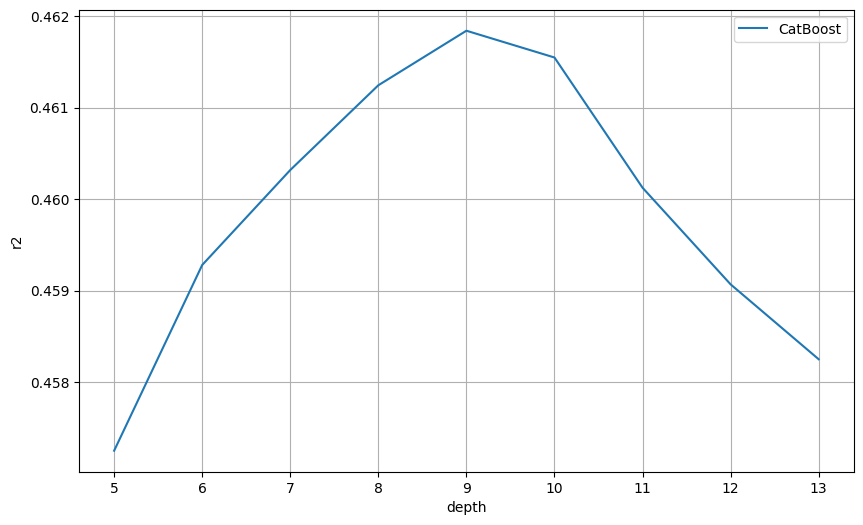

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(5, 14), metrics, label='CatBoost')
plt.xlabel('depth')
plt.ylabel('r2')
plt.grid()
plt.legend()

In [11]:
best_depth = 9

boost_model = CatBoostRegressor(iterations=1000, depth=best_depth,
                                loss_function='MAE', verbose=False, pinned_memory_size=2)
boost_model.fit(train_data_boost)

train_y_pred = boost_model.predict(train_data_boost)
test_y_pred = boost_model.predict(test_data_boost)

train_r2 = r2_score(y_train, train_y_pred)
test_r2 = r2_score(y_test, test_y_pred)

In [12]:
test_r2

0.4753678981759535

In [13]:
data_scoring_boost = pd.read_csv('data_scoring.csv', index_col='track_id')
data_scoring_boost.head()

,artist_name,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
track_id,,,,,,,,,,,,,,,
6D8WgDaIuyirn6egGauzVK,RITUAL,Love Me Back,0.498,0.745,178233,0.664,0.000008,1,0.0777,-4.280,1,0.0613,108.067,4,0.468
7ywsuXRTQ9xNKhZSmSD3Q0,Dalton Mauldin,Nights Without You,0.221,0.539,157751,0.536,0.000000,5,0.4940,-8.722,1,0.0552,183.784,4,0.725
1eoGO19WEflJbAV8BLebhr,Pandrezz,Orion,0.805,0.684,152000,0.255,0.790000,10,0.0884,-9.381,0,0.0445,84.226,4,0.330
3G79AJm9H5lKnngSgBT21L,Mc Davi,Ela Tá Que Tá,0.128,0.750,206829,0.418,0.000000,0,0.1280,-10.011,1,0.0496,123.007,4,0.253
2htWos5rGxFWSfLTyvpymm,G-Eazy,But A Dream - Alex Lustig Remix,0.401,0.563,198058,0.633,0.000000,5,0.1090,-6.252,0,0.2700,156.000,4,0.306


In [15]:
data_scoring_boost = data_scoring_boost.drop('track_name', 1)

<ipython-input-15-36acc5043488>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_scoring_boost = data_scoring_boost.drop('track_name', 1)


In [18]:
scoring_preds = boost_model.predict(data_scoring_boost)
submission_boost = pd.Series(scoring_preds, index=data_scoring_boost.index, name='popularity')
submission_boost.head()

track_id
6D8WgDaIuyirn6egGauzVK    27.428564
7ywsuXRTQ9xNKhZSmSD3Q0    22.299190
1eoGO19WEflJbAV8BLebhr    32.816482
3G79AJm9H5lKnngSgBT21L    39.375532
2htWos5rGxFWSfLTyvpymm    52.419782
Name: popularity, dtype: float64

In [19]:
submission_boost.to_csv('catboost_submission.csv')